# ScoreCard ML Pipeline Demo

This notebook demonstrates the refactored ScoreCard package with multi-horizon prediction support.

**Horizons:**
- **H1**: Predict the next scorecard (1 step ahead)
- **H2**: Predict the scorecard after next (2 steps ahead)

## 1. Imports and Setup

In [2]:
# Standard imports
import warnings
warnings.filterwarnings('ignore')

# Import the scorecard package
from scorecard import (
    ScoreCardConfig,
    ScoreCardState,
    ConnectionManager,
    ScoreCardTextPrep,
    ScoreCardModeling,
    ScoreCardPipeline,
    ScoreCardRag,
    Horizon,
    SUPPORTED_HORIZONS,
    run_pipeline,
    # New upload and reports modules
    upload_predictions_to_sql,
    build_upload_table,
    enrich_for_reporting,
    generate_summary_tables,
    plot_prediction_dashboard,
    display_flagged_notes,
    generate_flagged_report,
    # Model validation functions
    compute_baseline_metrics,
    plot_baseline_comparison,
    compute_calibration_metrics,
    plot_calibration_curves,
    plot_precision_recall_curves,
    analyze_temporal_performance,
    plot_temporal_performance,
    analyze_errors,
    plot_error_analysis,
    extract_feature_importance,
    plot_feature_importance,
    generate_word_clouds,
    generate_model_validation_report,
)

print("All imports successful!")
print(f"Supported horizons: {[f'H{int(h)}' for h in SUPPORTED_HORIZONS]}")

All imports successful!
Supported horizons: ['H1', 'H2']


## 2. Configuration

Configure the pipeline settings. You can customize paths, enable/disable stages, and set model parameters.

**Note:** File paths are automatically resolved relative to the package location, so you can run this notebook from any directory.

In [3]:
# Create configuration with custom settings
config = ScoreCardConfig(
    # === Data Sources ===
    sql_download=True,          # Set False to load from Elasticsearch instead
    
    # === Pipeline Stages ===
    enable_nlp=True,            # Run spaCy NLP enrichment
    build_models=True,          # Train ML models
    run_predictions=True,       # Generate predictions
    build_rag=True,             # Build RAG embeddings for GPT
    
    # === Model Configuration ===
    # Use predetermined model keys (fast) or set to None for grid search
    default_model_key_h1="complete_main_words_only | no_downsample_weighted | count | {0: 0.5, 1: 1.35, 2: 1.15}",
    default_model_key_h2="complete_main_words_only | no_downsample_weighted | count | {0: 0.5, 1: 1.35, 2: 1.15}",
    
    # === Training Settings ===
    training_length=5,          # Minimum notes needed per SID for training
)

print("Configuration created:")
print(f"  - SQL Download: {config.sql_download}")
print(f"  - Build Models: {config.build_models}")
print(f"  - Model Matrix JSON: {config.model_matrix_json}")
print(f"  - H1 Model Key: {config.default_model_key_h1[:50]}...")
print(f"  - H2 Model Key: {config.default_model_key_h2[:50]}...")

Configuration created:
  - SQL Download: True
  - Build Models: True
  - Model Matrix JSON: /home/jovyan/silver-iguana/Lastest_Spark/spark_jan/prompts/model_matrix.json
  - H1 Model Key: complete_main_words_only | no_downsample_weighted ...
  - H2 Model Key: complete_main_words_only | no_downsample_weighted ...


## 3. Verify File Paths

Check that all required config files are accessible.

In [4]:
import os

files_to_check = [
    ("Model Matrix JSON", config.model_matrix_json),
    ("SQL Query File", config.sql_query_file),
    ("GPT Prompt", config.gpt_prompt_location),
]

print("File Path Verification:")
print("=" * 60)
all_ok = True
for name, path in files_to_check:
    exists = os.path.exists(path)
    status = "✓" if exists else "✗ MISSING"
    print(f"  {status} {name}: {path}")
    if not exists:
        all_ok = False

if all_ok:
    print("\nAll files found! Ready to run pipeline.")
else:
    print("\n⚠️  Some files are missing. Check your prompts/ folder.")

File Path Verification:
  ✓ Model Matrix JSON: /home/jovyan/silver-iguana/Lastest_Spark/spark_jan/prompts/model_matrix.json
  ✓ SQL Query File: /home/jovyan/silver-iguana/Lastest_Spark/spark_jan/prompts/sql_query.txt
  ✓ GPT Prompt: /home/jovyan/silver-iguana/Lastest_Spark/spark_jan/prompts/GPT_Prompt.txt

All files found! Ready to run pipeline.


## 4. Run the Full Pipeline

The `run_pipeline()` function handles all initialization and execution.

In [ ]:
# Run the full pipeline
# This will:
#   1. Download data from SQL (or load from ES)
#   2. Run NLP enrichment with spaCy
#   3. Build sliding windows for each SID
#   4. Train models for H1 and H2 horizons
#   5. Generate predictions
#   6. Build RAG embeddings (optional)

state, pipeline, rag = run_pipeline(
    sql_download=config.sql_download,
    enable_nlp=config.enable_nlp,
    build_models=config.build_models,
    run_predictions=config.run_predictions,
    build_rag=config.build_rag,
)

[INIT] 	Initializing ScoreCardState...
[INIT] 	==================================================
[INIT] 	Loading model matrices from: /home/jovyan/silver-iguana/Lastest_Spark/spark_jan/prompts/model_matrix.json
[INIT] 	  -> 3 feature sets
[INIT] 	  -> 3 sampling strategies
[INIT] 	  -> 1 vectorization configs
[INIT] 	  -> 3 class weight configs
[INIT] 	Initializing spaCy model: en_core_web_trf
[INIT] 	  -> Activating GPU for spaCy...
[INIT] 	  -> WARNING: GPU requested but not available. Using CPU.
[INIT] 	  -> Loading model 'en_core_web_trf'...
[INIT] 	  -> spaCy model loaded in 3.2s
[INIT] 	Loading SQL query from: /home/jovyan/silver-iguana/Lastest_Spark/spark_jan/prompts/sql_query.txt
[INIT] 	  -> SQL query loaded (1475 chars)
[INIT] 	Loading GPT prompt from: /home/jovyan/silver-iguana/Lastest_Spark/spark_jan/prompts/GPT_Prompt.txt
[INIT] 	  -> GPT prompt loaded (2236 chars)
[INIT] 	==================================================
[INIT] 	ScoreCardState initialization complete!
[

## 5. Inspect Results

In [7]:
# Check the enriched dataframe
print("=" * 60)
print("ENRICHED DATAFRAME")
print("=" * 60)
if state.enriched_df is not None:
    print(f"Shape: {state.enriched_df.shape}")
    print(f"Columns: {list(state.enriched_df.columns[:10])}...")
    display(state.enriched_df.head(3))
else:
    print("Not available")

ENRICHED DATAFRAME
Shape: (29282, 42)
Columns: ['SID', 'Scorecard_Detail_Note_SID', 'Scorecard_Note', 'Note_Year', 'Note_Month', 'PO_Number', 'PO_Contract_Type', 'PO_Complexity_Level', 'PO_Lifecycle_Phase', 'Supplier_Name']...


,SID,Scorecard_Detail_Note_SID,Scorecard_Note,Note_Year,Note_Month,PO_Number,PO_Contract_Type,PO_Complexity_Level,PO_Lifecycle_Phase,Supplier_Name,...,Archive_Indicator,sid_key,pre_scrub_text,verbs,adjectives,noun_chunks,main_words,target,next_color_code,note_history
0,1,927,PO Contract value in the General Section does ...,2017,12,HA80E5771,CPFF,1,Production,NORTHROP GRUMMAN SYSTEMS CORPORATION,...,Y,000001.2017.12.000927,PO Contract value in the General Section does ...,reflect,total basic,PO Contract value the General Section the Tota...,reflect total basic po contract value the gene...,0,0,
1,1,1,OLGASim LOS Bias Error Insertion8,2018,02,HA80E5771,CPFF,1,Production,NORTHROP GRUMMAN SYSTEMS CORPORATION,...,Y,000001.2018.02.000001,OLGASim LOS Bias Error Insertion8,,,OLGASim LOS Bias Error Insertion8,olgasim los bias error insertion8,0,0,927
2,1,2,conduct initial delivery 4 MCSB-2 IT&E capabil...,2018,02,HA80E5771,CPFF,1,Production,NORTHROP GRUMMAN SYSTEMS CORPORATION,...,Y,000001.2018.02.000002,conduct initial delivery 4 MCSB-2 IT&E capabil...,conduct,initial complete,initial delivery 4 MCSB-2,conduct initial complete initial delivery 4 mc...,0,0,927;1


In [8]:
# Check the SID history windows
print("=" * 60)
print("SID HISTORY WINDOWS (Training Data)")
print("=" * 60)
if state.sid_df is not None:
    print(f"Shape: {state.sid_df.shape}")
    
    # Show key columns
    key_cols = ['sid', 'trainable', 'trainable_h2', 'target', 'target_h2', 'color_set', 'all_green']
    available_cols = [c for c in key_cols if c in state.sid_df.columns]
    display(state.sid_df[available_cols].head(5))
    
    # Stats
    print(f"\nH1 Trainable rows: {state.sid_df['trainable'].sum()}")
    if 'trainable_h2' in state.sid_df.columns:
        print(f"H2 Trainable rows: {state.sid_df['trainable_h2'].sum()}")
else:
    print("Not available")

SID HISTORY WINDOWS (Training Data)
Shape: (25964, 33)


,sid,trainable,trainable_h2,target,target_h2,color_set,all_green
0,1,True,True,0,0,GGGG,1
1,1,True,True,0,0,GGGG,1
2,1,True,True,0,0,GGGG,1
3,1,True,True,0,0,GGGG,1
4,1,True,True,0,0,GGGG,1



H1 Trainable rows: 25048
H2 Trainable rows: 24193


In [9]:
# Check model results by horizon
print("=" * 60)
print("MODEL RESULTS BY HORIZON")
print("=" * 60)

for h_int, key in state.best_model_key_by_horizon.items():
    print(f"\n--- Horizon H{h_int} ---")
    print(f"Best Model Key: {key}")
    
    model_info = state.best_model_by_horizon.get(h_int, {})
    if model_info:
        print(f"Accuracy: {model_info.get('accuracy', 'N/A'):.4f}")
        print(f"False Negatives: {model_info.get('total_false_negatives', 'N/A')}")
        print(f"Class Weights: {model_info.get('class_weights', 'N/A')}")

MODEL RESULTS BY HORIZON

--- Horizon H1 ---
Best Model Key: H1 | complete_main_words_only | no_downsample_weighted | count | Weights {0: 0.5, 1: 1.35, 2: 1.15}
Accuracy: 0.9651
False Negatives: 83
Class Weights: {0: 0.5, 1: 1.35, 2: 1.15}

--- Horizon H2 ---
Best Model Key: H2 | complete_main_words_only | no_downsample_weighted | count | Weights {0: 0.5, 1: 1.35, 2: 1.15}
Accuracy: 0.9731
False Negatives: 57
Class Weights: {0: 0.5, 1: 1.35, 2: 1.15}


In [10]:
# Check predictions
print("=" * 60)
print("PREDICTIONS")
print("=" * 60)

if state.complete_df is not None:
    print(f"Complete DataFrame shape: {state.complete_df.shape}")
    
    # Show prediction columns
    pred_cols = ['sid_key', 'predicted_color', 'prob_green', 'prob_yellow', 'prob_red']
    if 'predicted_color_h2' in state.complete_df.columns:
        pred_cols.extend(['predicted_color_h2', 'prob_green_h2', 'prob_yellow_h2', 'prob_red_h2'])
    
    available_cols = [c for c in pred_cols if c in state.complete_df.columns]
    display(state.complete_df[available_cols].head(10))
    
    # Prediction distribution
    if 'predicted_color' in state.complete_df.columns:
        print("\nH1 Prediction Distribution:")
        print(state.complete_df['predicted_color'].value_counts())
    
    if 'predicted_color_h2' in state.complete_df.columns:
        print("\nH2 Prediction Distribution:")
        print(state.complete_df['predicted_color_h2'].value_counts())
else:
    print("Not available")

PREDICTIONS
Complete DataFrame shape: (29282, 61)


,sid_key,predicted_color,prob_green,prob_yellow,prob_red,predicted_color_h2,prob_green_h2,prob_yellow_h2,prob_red_h2
0,000001.2017.12.000927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001.2018.02.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001.2018.02.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000001.2018.02.000003,Green,0.981678,0.017538,0.000784,Green,0.996945,0.002598,0.000457
4,000001.2018.02.000004,Green,0.988801,0.010300,0.000900,Green,0.992948,0.006205,0.000846
5,000001.2018.02.000005,Green,0.988190,0.011203,0.000607,Green,0.987267,0.012031,0.000702
6,000001.2018.02.000006,Green,0.976389,0.021143,0.002468,Green,0.976663,0.019566,0.003771
7,000001.2018.06.002229,Green,0.968093,0.029249,0.002658,Green,0.971008,0.025938,0.003054
8,000001.2019.01.001001,Green,0.987039,0.011908,0.001053,Green,0.987257,0.012049,0.000695
9,000001.2019.01.002228,Green,0.971077,0.027122,0.001801,Green,0.963485,0.035288,0.001227



H1 Prediction Distribution:
predicted_color
Green     20864
Yellow     4087
Red        1013
Name: count, dtype: int64

H2 Prediction Distribution:
predicted_color_h2
Green     20831
Yellow     4128
Red        1005
Name: count, dtype: int64


## 6. Manual Step-by-Step Execution (Alternative)

If you prefer more control, you can run each component manually:

In [11]:
# Manual execution example (commented out - uncomment to use)
"""
# Step 1: Create config and state
config = ScoreCardConfig(
    sql_download=False,  # Load from ES instead
    build_models=True,
)
state = ScoreCardState(config=config)

# Step 2: Initialize connections
conn = ConnectionManager(config=config, state=state)

# Step 3: Load data from Elasticsearch
state.enriched_df = conn.load_from_es(index_name="scorecard_enriched", id_col="sid_key")
state.sid_df = conn.load_from_es(index_name="scorecard_sid_history")

# Step 4: Train models
modeler = ScoreCardModeling(config=config, state=state, conn=conn)
modeler.build_model_grid()

# Train H1
modeler.find_best_model(horizon=Horizon.H1)
modeler.predict_with_best_model(state.sid_df, horizon=Horizon.H1)

# Train H2
modeler.find_best_model(horizon=Horizon.H2)
modeler.predict_with_best_model(state.sid_df, horizon=Horizon.H2)

# Merge predictions
modeler.merge_data()

# Step 5: Generate GPT justifications (optional)
rag = ScoreCardRag(config=config, state=state, conn=conn)
rag.embed_and_index_notes()
rag.generate_justifications(anchor_sid_key="000123.2024.06.000456", printer=True)
"""
print("Manual execution example is available in comments above.")

Manual execution example is available in comments above.


## 7. RAG and GPT Justifications

In [12]:
# Generate a GPT justification for a specific note
# (Requires RAG index to be built first)

if state.complete_df is not None and len(state.complete_df) > 0:
    # Pick a sample sid_key
    sample_sid_key = state.complete_df['sid_key'].iloc[0]
    print(f"Sample sid_key: {sample_sid_key}")
    
    # Uncomment to generate justification:
    # rag.generate_justifications(anchor_sid_key=sample_sid_key, printer=True)
else:
    print("No data available for RAG demo")

Sample sid_key: 000001.2017.12.000927


## 8. Summary

In [13]:
print("=" * 60)
print("PIPELINE SUMMARY")
print("=" * 60)

summary = {
    "Enriched Notes": len(state.enriched_df) if state.enriched_df is not None else 0,
    "Training Windows": len(state.sid_df) if state.sid_df is not None else 0,
    "Complete DataFrame": len(state.complete_df) if state.complete_df is not None else 0,
    "Models Trained": len(state.best_model_key_by_horizon),
    "Horizons": list(state.best_model_key_by_horizon.keys()),
}

for key, value in summary.items():
    print(f"{key}: {value}")

print("\nPipeline complete!")

PIPELINE SUMMARY
Enriched Notes: 29282
Training Windows: 25964
Complete DataFrame: 29282
Models Trained: 2
Horizons: [1, 2]

Pipeline complete!


## 9. Test Set Confusion Matrix Analysis

Visualize the confusion matrix for the TEST set to understand model performance across color classes.

TEST SET CONFUSION MATRICES

--- Horizon H1 ---


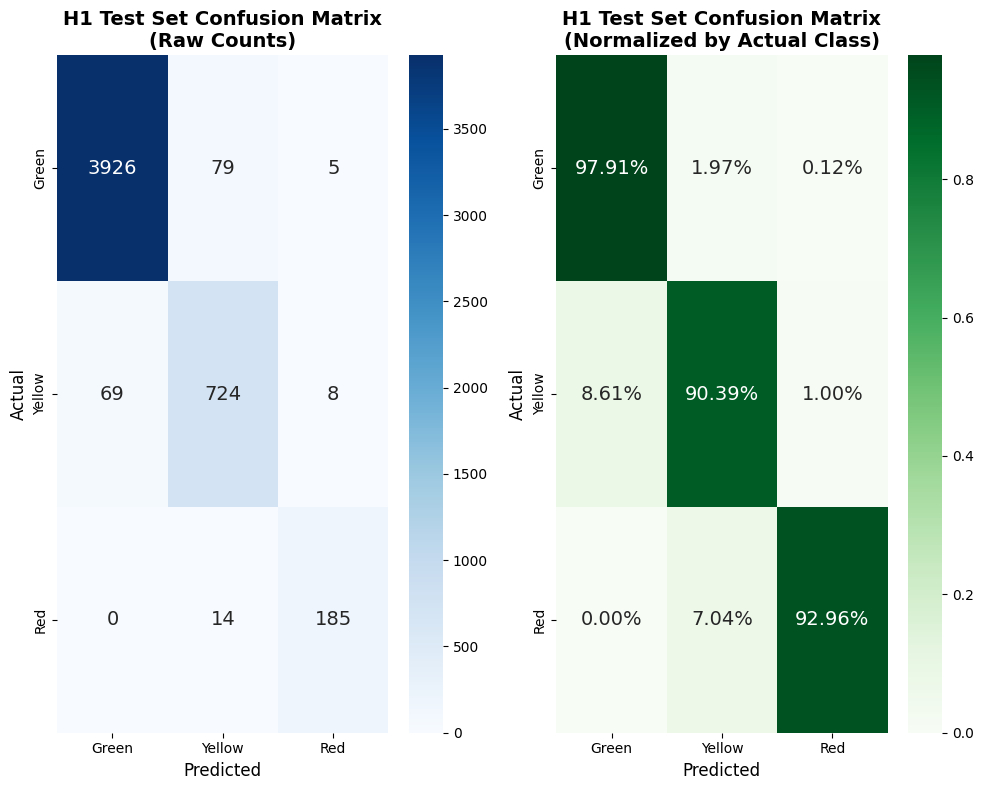


H1 TEST SET METRICS
Overall Accuracy: 0.9651 (96.51%)
Total False Negatives (missed risk): 83

Per-Class Performance:
  Green   : Recall=0.979, Precision=0.983, Support=4010
  Yellow  : Recall=0.904, Precision=0.886, Support=801
  Red     : Recall=0.930, Precision=0.934, Support=199

--- Horizon H2 ---


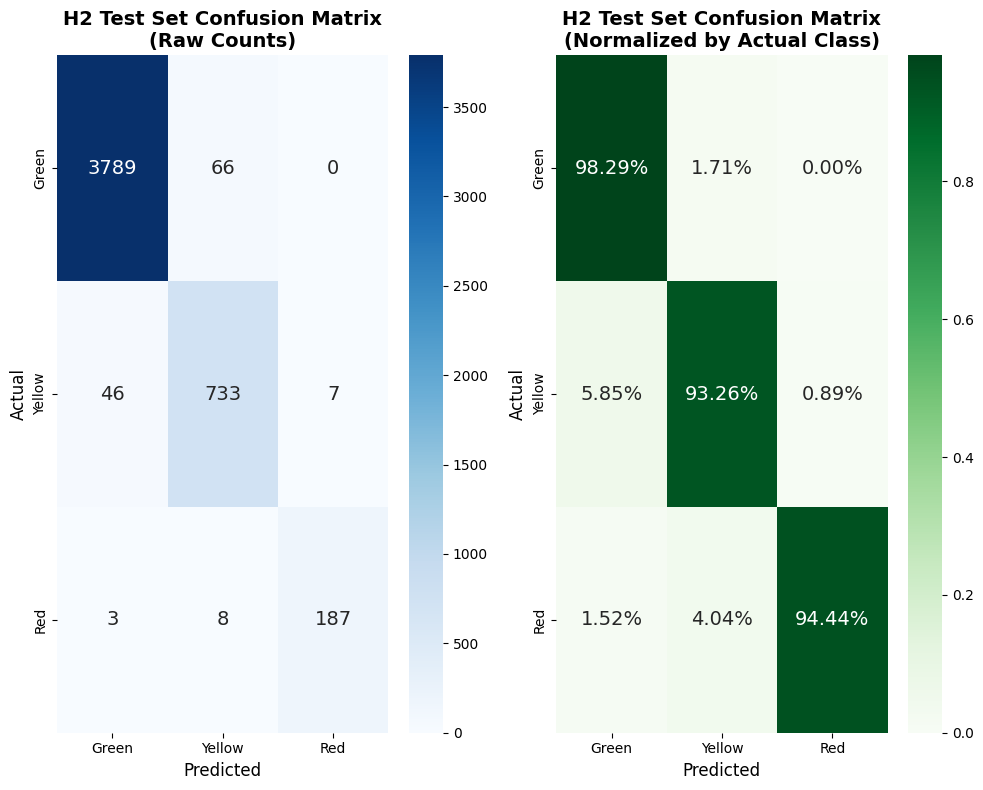


H2 TEST SET METRICS
Overall Accuracy: 0.9731 (97.31%)
Total False Negatives (missed risk): 57

Per-Class Performance:
  Green   : Recall=0.983, Precision=0.987, Support=3855
  Yellow  : Recall=0.933, Precision=0.908, Support=786
  Red     : Recall=0.944, Precision=0.964, Support=198


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix_for_horizon(state, horizon_int, figsize=(10, 8)):
    """
    Plot confusion matrix for the TEST set of a given horizon.
    
    The model stores test set predictions during training, so we can
    reconstruct the confusion matrix from the stored model info.
    """
    model_info = state.best_model_by_horizon.get(horizon_int, {})
    
    if not model_info:
        print(f"No model info found for H{horizon_int}")
        return
    
    # Get confusion matrix from stored model info
    cm = model_info.get('confusion_matrix')
    
    if cm is None:
        print(f"No confusion matrix stored for H{horizon_int}")
        return
    
    # Convert to numpy array if needed
    if hasattr(cm, 'values'):
        cm = cm.values
    
    labels = ['Green', 'Yellow', 'Red']
    
    # Create figure with two subplots: raw counts and normalized
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Raw counts
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax1,
                annot_kws={'size': 14})
    ax1.set_xlabel('Predicted', fontsize=12)
    ax1.set_ylabel('Actual', fontsize=12)
    ax1.set_title(f'H{horizon_int} Test Set Confusion Matrix\n(Raw Counts)', fontsize=14, fontweight='bold')
    
    # Plot 2: Normalized by row (recall perspective)
    ax2 = axes[1]
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=ax2,
                annot_kws={'size': 14})
    ax2.set_xlabel('Predicted', fontsize=12)
    ax2.set_ylabel('Actual', fontsize=12)
    ax2.set_title(f'H{horizon_int} Test Set Confusion Matrix\n(Normalized by Actual Class)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    accuracy = model_info.get('accuracy', 0)
    false_negs = model_info.get('total_false_negatives', 0)
    
    print(f"\n{'='*60}")
    print(f"H{horizon_int} TEST SET METRICS")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Total False Negatives (missed risk): {false_negs}")
    
    # Per-class metrics
    print(f"\nPer-Class Performance:")
    for i, label in enumerate(labels):
        total_actual = cm[i].sum()
        correct = cm[i, i]
        recall = correct / total_actual if total_actual > 0 else 0
        
        total_predicted = cm[:, i].sum()
        precision = correct / total_predicted if total_predicted > 0 else 0
        
        print(f"  {label:8s}: Recall={recall:.3f}, Precision={precision:.3f}, Support={total_actual}")

# Plot confusion matrices for both horizons
print("=" * 60)
print("TEST SET CONFUSION MATRICES")
print("=" * 60)

for h_int in state.best_model_key_by_horizon.keys():
    print(f"\n--- Horizon H{h_int} ---")
    plot_confusion_matrix_for_horizon(state, h_int)

## 9b. Baseline Comparison - Does the Model Beat Simple Heuristics?

A critical question: since scorecards often **stay the same color**, can the model actually outperform simply predicting "same as last time"? We compare against two baselines:
- **Persist Baseline**: Always predict the last known color (the strongest naive baseline for this problem)
- **Majority Baseline**: Always predict the most common class (Green)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Helper: extract test-set arrays from model info ----
def get_test_set_data(state, horizon_int):
    """
    Extract y_true, y_pred, y_proba, and last_colors from the stored model info.
    Falls back to reconstructing from sid_df if test arrays not stored directly.
    """
    model_info = state.best_model_by_horizon.get(horizon_int, {})

    # Try to get stored test set data
    y_test = model_info.get('y_test')
    y_pred = model_info.get('y_pred')
    y_proba = model_info.get('y_proba')

    # If test arrays stored directly, use them
    if y_test is not None and y_pred is not None:
        y_test = np.asarray(y_test)
        y_pred = np.asarray(y_pred)
        if y_proba is not None:
            y_proba = np.asarray(y_proba)
        return y_test, y_pred, y_proba

    # Otherwise, reconstruct from sid_df using the trained model
    print(f"  Reconstructing test set for H{horizon_int} from sid_df...")

    sid_df = state.sid_df
    target_col = 'target' if horizon_int == 1 else f'target_h{horizon_int}'
    trainable_col = 'trainable' if horizon_int == 1 else f'trainable_h{horizon_int}'

    # Filter trainable rows
    mask = sid_df[trainable_col] == True
    if target_col in sid_df.columns:
        mask = mask & sid_df[target_col].isin([0, 1, 2])
    df_filtered = sid_df[mask].copy()

    # Get the model and vectorizer
    clf = model_info.get('model')
    vectorizer = model_info.get('vectorizer')
    text_col = model_info.get('text_column', 'complete_main_words')

    if clf is None or vectorizer is None:
        print(f"  WARNING: Model or vectorizer not found for H{horizon_int}")
        return None, None, None

    # Recreate train/test split (same random_state as used in training)
    from sklearn.model_selection import train_test_split

    y_all = df_filtered[target_col].values
    X_text = df_filtered[text_col].fillna('')

    X_vec = vectorizer.transform(X_text)

    X_train, X_test, y_train, y_test_out, idx_train, idx_test = train_test_split(
        X_vec, y_all, df_filtered.index, test_size=0.2, random_state=42, stratify=y_all
    )

    y_pred_out = clf.predict(X_test)
    y_proba_out = clf.predict_proba(X_test) if hasattr(clf, 'predict_proba') else None

    return y_test_out, y_pred_out, y_proba_out


# ---- Run baseline comparison for each horizon ----
print("=" * 70)
print("BASELINE COMPARISON")
print("=" * 70)

for h_int in state.best_model_key_by_horizon.keys():
    print(f"\n--- Horizon H{h_int} ---")

    y_true, y_pred, y_proba = get_test_set_data(state, h_int)

    if y_true is None:
        print("  Could not extract test set data")
        continue

    # For baseline: last color is the last char of color_set mapped to numeric
    # We reconstruct from the test indices
    target_col = 'target' if h_int == 1 else f'target_h{h_int}'
    trainable_col = 'trainable' if h_int == 1 else f'trainable_h{h_int}'

    mask = (state.sid_df[trainable_col] == True) & state.sid_df[target_col].isin([0, 1, 2])
    df_filtered = state.sid_df[mask].copy()

    # Get last color from color_set
    color_to_num = {'G': 0, 'Y': 1, 'R': 2}
    df_filtered['_last_color_num'] = df_filtered['color_set'].fillna('').str[-1].map(color_to_num).fillna(0).astype(int)

    # Recreate same split to get last_colors for test set
    from sklearn.model_selection import train_test_split
    _, _, _, _, idx_train, idx_test = train_test_split(
        df_filtered.index, df_filtered[target_col].values,
        test_size=0.2, random_state=42, stratify=df_filtered[target_col].values
    )
    last_colors = df_filtered.loc[idx_test, '_last_color_num'].values

    # Compute and display baseline comparison
    metrics = compute_baseline_metrics(y_true, y_pred, last_colors)

    print(f"  Model Accuracy:     {metrics['model_accuracy']:.4f}")
    print(f"  Persist Baseline:   {metrics['persist_accuracy']:.4f}")
    print(f"  Majority Baseline:  {metrics['majority_accuracy']:.4f} (always predict {metrics['majority_class']})")
    print(f"  Lift over Persist:  {metrics['lift_over_persist']:+.1f}%")
    print(f"  Lift over Majority: {metrics['lift_over_majority']:+.1f}%")

    fig = plot_baseline_comparison(y_true, y_pred, last_colors)
    fig.suptitle(f"H{h_int} - Model vs Baselines", fontsize=14, fontweight="bold", y=1.02)
    plt.show()

BASELINE COMPARISON

--- Horizon H1 ---
  Reconstructing test set for H1 from sid_df...


AttributeError: 'str' object has no attribute 'transform'

## 9c. Calibration Analysis

When the model says "80% confident it's Yellow," is it actually Yellow 80% of the time? Calibration curves answer this. A well-calibrated model's probabilities can be trusted for flagging thresholds.

In [16]:
print("=" * 70)
print("CALIBRATION ANALYSIS")
print("=" * 70)

for h_int in state.best_model_key_by_horizon.keys():
    print(f"\n--- Horizon H{h_int} ---")

    y_true, y_pred, y_proba = get_test_set_data(state, h_int)

    if y_true is None or y_proba is None:
        print("  Could not extract probability data")
        continue

    # Compute calibration metrics
    cal_metrics = compute_calibration_metrics(y_true, y_proba)

    print(f"  Overall Brier Score: {cal_metrics['overall_brier']:.4f} (lower is better)")
    print(f"  Per-Class Brier Scores:")
    for cls, score in cal_metrics['brier_scores'].items():
        quality = "Good" if score < 0.05 else "Fair" if score < 0.15 else "Needs improvement"
        print(f"    {cls:8s}: {score:.4f} ({quality})")

    # Plot calibration curves
    fig = plot_calibration_curves(y_true, y_proba)
    fig.suptitle(f"H{h_int} - Calibration Curves", fontsize=14, fontweight="bold", y=1.02)
    plt.show()

CALIBRATION ANALYSIS

--- Horizon H1 ---
  Reconstructing test set for H1 from sid_df...


AttributeError: 'str' object has no attribute 'transform'

## 9d. Precision-Recall Curves

For imbalanced datasets (many Greens, few Reds), accuracy is misleading. PR curves show performance for each class, especially the minority classes (Yellow, Red) that matter most for risk detection.

In [17]:
print("=" * 70)
print("PRECISION-RECALL CURVES")
print("=" * 70)
print("\nAverage Precision (AP) measures the area under the PR curve.")
print("Higher is better. Baseline = class prevalence (random classifier).\n")

for h_int in state.best_model_key_by_horizon.keys():
    print(f"\n--- Horizon H{h_int} ---")

    y_true, y_pred, y_proba = get_test_set_data(state, h_int)

    if y_true is None or y_proba is None:
        print("  Could not extract probability data")
        continue

    # Print class distribution for context
    unique, counts = np.unique(y_true, return_counts=True)
    class_names = ["Green", "Yellow", "Red"]
    total = len(y_true)
    print(f"  Test set class distribution:")
    for cls_id, cnt in zip(unique, counts):
        print(f"    {class_names[cls_id]:8s}: {cnt:5d} ({100*cnt/total:.1f}%)")

    # Plot PR curves
    fig = plot_precision_recall_curves(y_true, y_proba)
    fig.suptitle(f"H{h_int} - Precision-Recall Curves", fontsize=14, fontweight="bold", y=1.02)
    plt.show()

PRECISION-RECALL CURVES

Average Precision (AP) measures the area under the PR curve.
Higher is better. Baseline = class prevalence (random classifier).


--- Horizon H1 ---
  Reconstructing test set for H1 from sid_df...


AttributeError: 'str' object has no attribute 'transform'

## 9e. Error Analysis

Deep dive into what the model gets wrong. High-confidence errors are the most dangerous - the model is confidently incorrect. Understanding error patterns helps identify model weaknesses.

In [18]:
import pandas as pd

print("=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)

for h_int in state.best_model_key_by_horizon.keys():
    print(f"\n--- Horizon H{h_int} ---")

    y_true, y_pred, y_proba = get_test_set_data(state, h_int)

    if y_true is None:
        print("  Could not extract test set data")
        continue

    # Build a temp dataframe for the error analysis
    confidence = y_proba.max(axis=1) if y_proba is not None else np.ones_like(y_true) * 0.5
    df_temp = pd.DataFrame({
        '_true': y_true,
        '_pred': y_pred,
        '_conf': confidence
    })

    # Run error analysis
    error_results = analyze_errors(df_temp, '_true', '_pred', '_conf')

    print(f"  Total Test Samples:    {error_results['total_samples']:,}")
    print(f"  Total Errors:          {error_results['total_errors']:,} ({error_results['error_rate']:.2%})")
    print(f"  High-Confidence Errors: {error_results['high_confidence_errors']:,} (conf >= 80%)")
    print(f"  Mean Confidence (Correct):  {error_results['mean_conf_correct']:.3f}")
    print(f"  Mean Confidence (Errors):   {error_results['mean_conf_errors']:.3f}")

    print(f"\n  Error Breakdown:")
    for error_type, count in error_results['error_type_counts'].items():
        print(f"    {error_type:25s}: {count}")

    # Plot error analysis
    fig = plot_error_analysis(df_temp, '_true', '_pred', '_conf')
    fig.suptitle(f"H{h_int} - Error Analysis", fontsize=16, fontweight="bold", y=1.02)
    plt.show()

    # Show sample high-confidence errors if any
    if error_results['high_confidence_errors'] > 0:
        class_names = ['Green', 'Yellow', 'Red']
        hce = error_results

        # Reconstruct from the temp df
        hce_df = df_temp[(df_temp['_true'] != df_temp['_pred']) & (df_temp['_conf'] >= 0.8)].copy()
        hce_df['true_label'] = hce_df['_true'].map(dict(enumerate(class_names)))
        hce_df['pred_label'] = hce_df['_pred'].map(dict(enumerate(class_names)))

        print(f"\n  Sample High-Confidence Errors (showing up to 5):")
        display(hce_df[['true_label', 'pred_label', '_conf']].head(5).rename(
            columns={'true_label': 'Actual', 'pred_label': 'Predicted', '_conf': 'Confidence'}
        ))

ERROR ANALYSIS

--- Horizon H1 ---
  Reconstructing test set for H1 from sid_df...


AttributeError: 'str' object has no attribute 'transform'

## 9f. Feature Importance - Top Predictive Words

What words drive the model's predictions? For linear models, we can examine the coefficient weights to understand which words push predictions toward Green, Yellow, or Red. This builds interpretability and trust.

In [19]:
print("=" * 70)
print("FEATURE IMPORTANCE - TOP PREDICTIVE WORDS")
print("=" * 70)

for h_int in state.best_model_key_by_horizon.keys():
    print(f"\n--- Horizon H{h_int} ---")

    model_info = state.best_model_by_horizon.get(h_int, {})
    clf = model_info.get('model')
    vectorizer = model_info.get('vectorizer')

    if clf is None or vectorizer is None:
        print("  Model or vectorizer not available for feature analysis")
        continue

    feature_names = vectorizer.get_feature_names_out()
    print(f"  Total features (vocabulary size): {len(feature_names):,}")

    # Extract and display feature importance
    importance = extract_feature_importance(clf, feature_names, top_n=15)

    class_names = ['Green', 'Yellow', 'Red']
    for cls in class_names:
        if cls in importance:
            top_pos = importance[cls]['top_positive'][:10]
            print(f"\n  Top 10 words predicting {cls}:")
            for word, coef in top_pos:
                print(f"    {word:30s}  {coef:+.4f}")

    # Plot feature importance chart
    fig = plot_feature_importance(clf, feature_names, top_n=15)
    if fig is not None:
        fig.suptitle(f"H{h_int} - Top Predictive Words by Class", fontsize=16, fontweight="bold", y=1.02)
        plt.show()

    # Attempt word clouds
    try:
        fig_wc = generate_word_clouds(clf, feature_names, top_n=100)
        if fig_wc is not None:
            fig_wc.suptitle(f"H{h_int} - Predictive Word Clouds", fontsize=16, fontweight="bold", y=1.02)
            plt.show()
    except Exception as e:
        print(f"  Word clouds skipped: {e}")

FEATURE IMPORTANCE - TOP PREDICTIVE WORDS

--- Horizon H1 ---


AttributeError: 'str' object has no attribute 'get_feature_names_out'

## 9g. Temporal Validation

Does the model degrade over time? In production, we train on historical data and predict future outcomes. Temporal analysis checks if model accuracy holds across different time periods and detects concept drift.

In [20]:
print("=" * 70)
print("TEMPORAL VALIDATION")
print("=" * 70)
print("\nAnalyzing model performance across time periods to detect drift.\n")

# Work with sid_df which has predictions and temporal info
sid_df = state.sid_df.copy()

# Determine date column
date_col = None
for candidate in ['Report_Date', 'Note_YearMonth']:
    if candidate in sid_df.columns:
        date_col = candidate
        break

if date_col is None and 'Note_Year' in sid_df.columns and 'Note_Month' in sid_df.columns:
    # Construct a sortable date proxy
    sid_df['_date_proxy'] = sid_df['Note_Year'].astype(int) * 100 + sid_df['Note_Month'].astype(int)
    date_col = '_date_proxy'

if date_col is not None:
    for h_int in state.best_model_key_by_horizon.keys():
        print(f"\n--- Horizon H{h_int} ---")

        target_col = 'target' if h_int == 1 else f'target_h{h_int}'
        trainable_col = 'trainable' if h_int == 1 else f'trainable_h{h_int}'
        pred_col = 'predicted_label' if h_int == 1 else f'predicted_label_h{h_int}'

        # Check if predictions exist in sid_df
        possible_pred_cols = [pred_col, 'predicted_label']
        actual_pred_col = None
        for pc in possible_pred_cols:
            if pc in sid_df.columns:
                actual_pred_col = pc
                break

        if actual_pred_col is None:
            # Fall back to mapping predicted_color
            color_col = 'predicted_color' if h_int == 1 else f'predicted_color_h{h_int}'
            if color_col not in sid_df.columns:
                print(f"  No prediction column found for H{h_int}")
                continue
            color_map = {'Green': 0, 'Yellow': 1, 'Red': 2}
            sid_df[f'_pred_num_h{h_int}'] = sid_df[color_col].map(color_map)
            actual_pred_col = f'_pred_num_h{h_int}'

        # Filter to rows with both target and predictions
        mask = (
            sid_df[trainable_col] == True
        ) & sid_df[target_col].isin([0, 1, 2]) & sid_df[actual_pred_col].notna()
        df_temporal = sid_df[mask].copy()

        if len(df_temporal) < 50:
            print(f"  Insufficient data for temporal analysis ({len(df_temporal)} rows)")
            continue

        # Analyze temporal performance
        perf = analyze_temporal_performance(
            df_temporal, date_col, target_col, actual_pred_col, n_periods=5
        )

        print(f"  {len(df_temporal):,} predictions analyzed across 5 time periods")
        print(f"\n  Period Performance:")
        for _, row in perf.iterrows():
            print(f"    Period {int(row['period'])}: Accuracy={row['accuracy']:.4f}  "
                  f"({int(row['n_samples']):,} samples, {row['date_start']} to {row['date_end']})")

        std_acc = perf['accuracy'].std()
        mean_acc = perf['accuracy'].mean()
        print(f"\n  Stability: Mean={mean_acc:.4f}, Std={std_acc:.4f}")
        if std_acc < 0.02:
            print(f"  Assessment: Stable performance across time periods")
        elif std_acc < 0.05:
            print(f"  Assessment: Moderate variation - monitor for drift")
        else:
            print(f"  Assessment: High variation - potential concept drift")

        # Plot
        fig = plot_temporal_performance(
            df_temporal, date_col, target_col, actual_pred_col, n_periods=5
        )
        fig.suptitle(f"H{h_int} - Performance Over Time", fontsize=14, fontweight="bold", y=1.02)
        plt.show()
else:
    print("No date column available for temporal analysis.")

TEMPORAL VALIDATION

Analyzing model performance across time periods to detect drift.

No date column available for temporal analysis.


## 10. Color Change Prediction Analysis

One challenge with this model is that scorecards often stay the same color over time. Here we analyze instances where the model predicts a color **change** in the horizon - these are particularly important for early warning detection.

In [21]:
import pandas as pd

def analyze_color_changes(df, horizon_suffix=''):
    """
    Analyze predicted color changes vs the last known color.
    
    Args:
        df: DataFrame with predictions
        horizon_suffix: '' for H1, '_h2' for H2
    """
    pred_col = f'predicted_color{horizon_suffix}'
    
    # Filter to rows with predictions
    has_pred = df[pred_col].notna()
    analysis_df = df[has_pred].copy()
    
    if len(analysis_df) == 0:
        print(f"No predictions found for {pred_col}")
        return None
    
    # Get last color from color_set (last character)
    if 'color_set' in analysis_df.columns:
        analysis_df['last_color'] = analysis_df['color_set'].fillna('').str[-1].str.upper()
        analysis_df['last_color'] = analysis_df['last_color'].map({'G': 'Green', 'Y': 'Yellow', 'R': 'Red'})
    else:
        print("No color_set column found")
        return None
    
    # Get predicted color (first letter normalized)
    analysis_df['pred_color'] = analysis_df[pred_col].str.strip().str.title()
    
    # Determine if prediction is a change
    analysis_df['is_change'] = analysis_df['last_color'] != analysis_df['pred_color']
    
    # Classify change direction
    color_order = {'Green': 0, 'Yellow': 1, 'Red': 2}
    analysis_df['last_order'] = analysis_df['last_color'].map(color_order)
    analysis_df['pred_order'] = analysis_df['pred_color'].map(color_order)
    
    def classify_change(row):
        if pd.isna(row['last_order']) or pd.isna(row['pred_order']):
            return 'Unknown'
        diff = row['pred_order'] - row['last_order']
        if diff == 0:
            return 'No Change'
        elif diff > 0:
            return 'Downgrade (Worse)'  # Moving toward Red
        else:
            return 'Upgrade (Better)'   # Moving toward Green
    
    analysis_df['change_type'] = analysis_df.apply(classify_change, axis=1)
    
    return analysis_df

# Analyze color changes for both horizons
print("=" * 70)
print("COLOR CHANGE PREDICTION ANALYSIS")
print("=" * 70)
print("\nNote: Scorecards often maintain the same color. Predicted CHANGES")
print("are especially valuable for early warning detection.\n")

for suffix, h_name in [('', 'H1 (Next Card)'), ('_h2', 'H2 (Card After Next)')]:
    pred_col = f'predicted_color{suffix}'
    
    if pred_col not in state.complete_df.columns:
        continue
        
    print(f"\n{'='*70}")
    print(f"{h_name} - Color Change Analysis")
    print(f"{'='*70}")
    
    analysis = analyze_color_changes(state.complete_df, suffix)
    
    if analysis is None:
        continue
    
    # Overall statistics
    total_predictions = len(analysis)
    total_changes = analysis['is_change'].sum()
    change_pct = 100 * total_changes / total_predictions
    
    print(f"\nOverall Statistics:")
    print(f"  Total Predictions: {total_predictions:,}")
    print(f"  Predicted Changes: {total_changes:,} ({change_pct:.1f}%)")
    print(f"  No Change:         {total_predictions - total_changes:,} ({100-change_pct:.1f}%)")
    
    # Change type breakdown
    print(f"\nChange Type Breakdown:")
    change_counts = analysis['change_type'].value_counts()
    for change_type, count in change_counts.items():
        pct = 100 * count / total_predictions
        print(f"  {change_type:20s}: {count:6,} ({pct:5.1f}%)")
    
    # Transition matrix
    print(f"\nTransition Matrix (Last Color -> Predicted Color):")
    transition = pd.crosstab(
        analysis['last_color'], 
        analysis['pred_color'],
        margins=True,
        margins_name='Total'
    )
    # Reorder columns/rows
    order = ['Green', 'Yellow', 'Red', 'Total']
    transition = transition.reindex(index=[o for o in order if o in transition.index],
                                     columns=[o for o in order if o in transition.columns])
    display(transition)

COLOR CHANGE PREDICTION ANALYSIS

Note: Scorecards often maintain the same color. Predicted CHANGES
are especially valuable for early warning detection.


H1 (Next Card) - Color Change Analysis

Overall Statistics:
  Total Predictions: 25,964
  Predicted Changes: 621 (2.4%)
  No Change:         25,343 (97.6%)

Change Type Breakdown:
  No Change           : 25,343 ( 97.6%)
  Downgrade (Worse)   :    319 (  1.2%)
  Upgrade (Better)    :    302 (  1.2%)

Transition Matrix (Last Color -> Predicted Color):


pred_color,Green,Yellow,Red,Total
last_color,,,,
Green,20608,262,10,20880
Yellow,250,3779,47,4076
Red,6,46,956,1008
Total,20864,4087,1013,25964



H2 (Card After Next) - Color Change Analysis

Overall Statistics:
  Total Predictions: 25,964
  Predicted Changes: 1,055 (4.1%)
  No Change:         24,909 (95.9%)

Change Type Breakdown:
  No Change           : 24,909 ( 95.9%)
  Downgrade (Worse)   :    555 (  2.1%)
  Upgrade (Better)    :    500 (  1.9%)

Transition Matrix (Last Color -> Predicted Color):


pred_color,Green,Yellow,Red,Total
last_color,,,,
Green,20405,463,12,20880
Yellow,405,3591,80,4076
Red,21,74,913,1008
Total,20831,4128,1005,25964



COLOR CHANGE VISUALIZATIONS


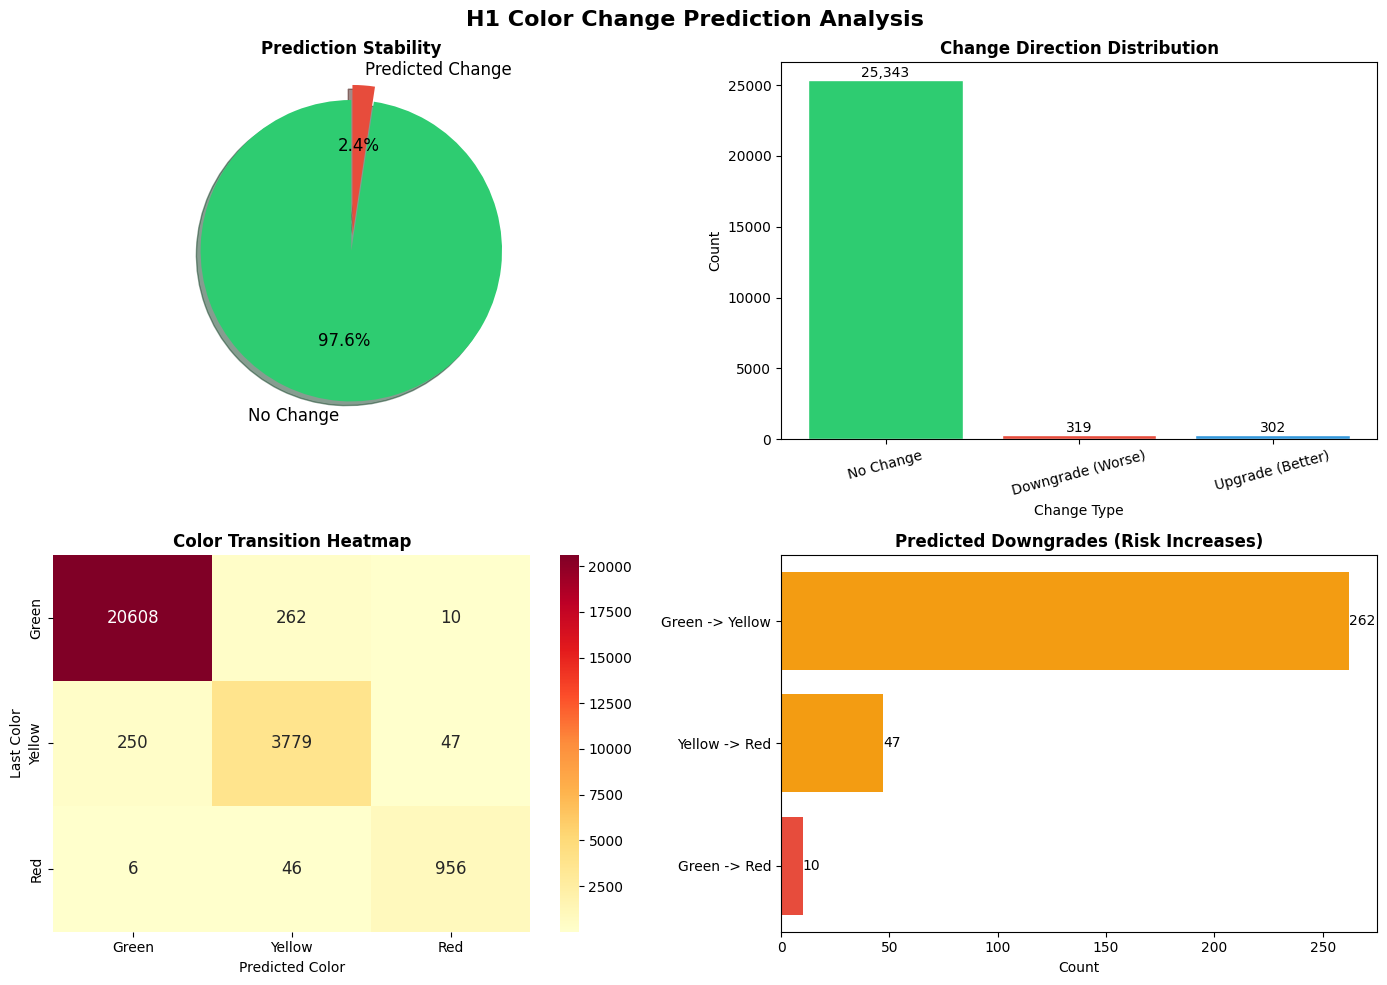

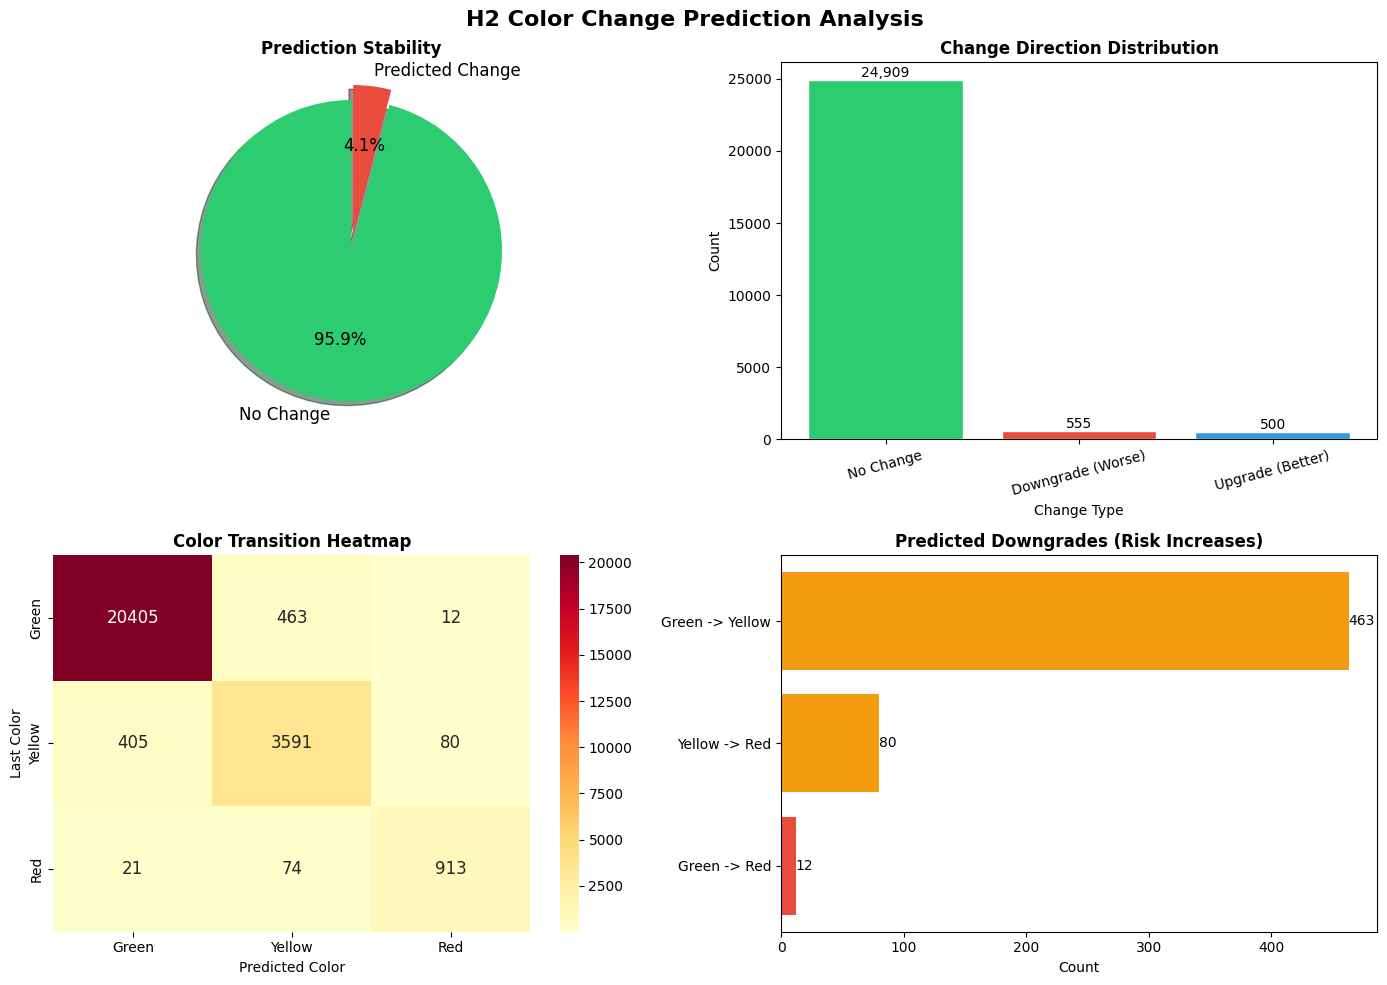

In [22]:
# Visualize color change predictions
def plot_color_change_analysis(df, horizon_suffix='', figsize=(14, 10)):
    """
    Visualize color change predictions with multiple charts.
    """
    pred_col = f'predicted_color{horizon_suffix}'
    h_name = 'H1' if horizon_suffix == '' else 'H2'
    
    analysis = analyze_color_changes(df, horizon_suffix)
    if analysis is None:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{h_name} Color Change Prediction Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Change vs No Change pie chart
    ax1 = axes[0, 0]
    change_summary = analysis['is_change'].value_counts()
    labels = ['No Change', 'Predicted Change']
    sizes = [change_summary.get(False, 0), change_summary.get(True, 0)]
    colors = ['#2ecc71', '#e74c3c']
    explode = (0, 0.1)
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12})
    ax1.set_title('Prediction Stability', fontsize=12, fontweight='bold')
    
    # Plot 2: Change direction breakdown
    ax2 = axes[0, 1]
    change_types = analysis['change_type'].value_counts()
    colors_map = {'No Change': '#2ecc71', 'Upgrade (Better)': '#3498db', 'Downgrade (Worse)': '#e74c3c'}
    bar_colors = [colors_map.get(ct, 'gray') for ct in change_types.index]
    bars = ax2.bar(change_types.index, change_types.values, color=bar_colors, edgecolor='white')
    ax2.set_xlabel('Change Type')
    ax2.set_ylabel('Count')
    ax2.set_title('Change Direction Distribution', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=15)
    for bar, val in zip(bars, change_types.values):
        ax2.annotate(f'{val:,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Heatmap of transitions
    ax3 = axes[1, 0]
    transition = pd.crosstab(analysis['last_color'], analysis['pred_color'])
    order = ['Green', 'Yellow', 'Red']
    transition = transition.reindex(index=[o for o in order if o in transition.index],
                                     columns=[o for o in order if o in transition.columns])
    sns.heatmap(transition, annot=True, fmt='d', cmap='YlOrRd', ax=ax3,
                annot_kws={'size': 12})
    ax3.set_xlabel('Predicted Color')
    ax3.set_ylabel('Last Color')
    ax3.set_title('Color Transition Heatmap', fontsize=12, fontweight='bold')
    
    # Plot 4: Sample predicted changes (downgrades are most critical)
    ax4 = axes[1, 1]
    downgrades = analysis[analysis['change_type'] == 'Downgrade (Worse)']
    if len(downgrades) > 0:
        # Show distribution of downgrade types
        downgrade_detail = downgrades.groupby(['last_color', 'pred_color']).size().reset_index(name='count')
        downgrade_detail['transition'] = downgrade_detail['last_color'] + ' -> ' + downgrade_detail['pred_color']
        downgrade_detail = downgrade_detail.sort_values('count', ascending=True)
        
        colors_down = ['#f39c12' if 'Yellow' in t else '#e74c3c' for t in downgrade_detail['transition']]
        bars = ax4.barh(downgrade_detail['transition'], downgrade_detail['count'], color=colors_down)
        ax4.set_xlabel('Count')
        ax4.set_title('Predicted Downgrades (Risk Increases)', fontsize=12, fontweight='bold')
        for bar, val in zip(bars, downgrade_detail['count']):
            ax4.annotate(f'{val:,}', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                        ha='left', va='center', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'No downgrades predicted', ha='center', va='center', fontsize=14)
        ax4.set_title('Predicted Downgrades', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot for both horizons
print("\n" + "=" * 70)
print("COLOR CHANGE VISUALIZATIONS")
print("=" * 70)

plot_color_change_analysis(state.complete_df, horizon_suffix='')
plot_color_change_analysis(state.complete_df, horizon_suffix='_h2')

In [23]:
# Show sample predicted downgrades (most critical for early warning)
print("=" * 70)
print("SAMPLE PREDICTED DOWNGRADES (Early Warning Candidates)")
print("=" * 70)
print("\nThese are instances where the model predicts a WORSE rating in the future.")
print("These predictions are valuable for proactive risk management.\n")

# Get H1 analysis
analysis_h1 = analyze_color_changes(state.complete_df, '')

if analysis_h1 is not None:
    downgrades = analysis_h1[analysis_h1['change_type'] == 'Downgrade (Worse)'].copy()
    
    if len(downgrades) > 0:
        # Sort by confidence in the downgrade prediction
        prob_cols = ['prob_green', 'prob_yellow', 'prob_red']
        downgrades['pred_confidence'] = downgrades.apply(
            lambda row: max([row.get(c, 0) for c in prob_cols if pd.notna(row.get(c))]), axis=1
        )
        
        # Show high-confidence downgrades
        high_conf_downgrades = downgrades[downgrades['pred_confidence'] > 0.6].sort_values(
            'pred_confidence', ascending=False
        )
        
        print(f"Total Predicted Downgrades (H1): {len(downgrades):,}")
        print(f"High Confidence Downgrades (>60%): {len(high_conf_downgrades):,}")
        
        # Display sample
        display_cols = ['sid_key', 'last_color', 'pred_color', 'pred_confidence', 
                       'color_set', 'prob_green', 'prob_yellow', 'prob_red']
        available_cols = [c for c in display_cols if c in high_conf_downgrades.columns]
        
        print(f"\nSample High-Confidence Downgrades (showing up to 10):")
        display(high_conf_downgrades[available_cols].head(10))
        
        # Breakdown by transition type
        print(f"\nDowngrade Breakdown by Transition:")
        transition_counts = downgrades.groupby(['last_color', 'pred_color']).size().reset_index(name='count')
        transition_counts['transition'] = transition_counts['last_color'] + ' -> ' + transition_counts['pred_color']
        transition_counts = transition_counts.sort_values('count', ascending=False)
        
        for _, row in transition_counts.iterrows():
            print(f"  {row['transition']:20s}: {row['count']:,} predictions")
    else:
        print("No downgrades predicted in H1")
else:
    print("Could not analyze color changes")

SAMPLE PREDICTED DOWNGRADES (Early Warning Candidates)

These are instances where the model predicts a WORSE rating in the future.
These predictions are valuable for proactive risk management.

Total Predicted Downgrades (H1): 319
High Confidence Downgrades (>60%): 286

Sample High-Confidence Downgrades (showing up to 10):


,sid_key,last_color,pred_color,pred_confidence,color_set,prob_green,prob_yellow,prob_red
3740,000319.2021.08.019053,Green,Yellow,1.000000,GGGG,1.141302e-09,1.000000e+00,2.454280e-13
3531,000308.2023.05.030023,Green,Yellow,1.000000,GGGG,1.543623e-08,1.000000e+00,7.590773e-10
20432,002799.2024.01.034443,Yellow,Red,1.000000,YYYY,2.449447e-08,3.024452e-11,1.000000e+00
3081,000295.2023.07.030826,Yellow,Red,0.999992,YYYY,7.363181e-13,8.158748e-06,9.999918e-01
3082,000295.2023.08.031223,Yellow,Red,0.999946,YYYY,7.366440e-06,4.677184e-05,9.999459e-01
3739,000319.2021.08.018909,Green,Yellow,0.999794,GGGG,2.055379e-04,9.997944e-01,2.097447e-08
10681,002507.2022.10.025829,Green,Yellow,0.999662,YYYG,3.177112e-04,9.996621e-01,2.021376e-05
2316,000203.2021.12.020744,Green,Yellow,0.999425,GGGG,5.737813e-04,9.994248e-01,1.426139e-06
7842,001423.2023.10.033089,Green,Yellow,0.999403,GYYG,5.869750e-04,9.994028e-01,1.022408e-05
7843,001423.2023.11.033566,Green,Yellow,0.999137,YYGG,8.628453e-04,9.991369e-01,2.366074e-07



Downgrade Breakdown by Transition:
  Green -> Yellow     : 262 predictions
  Yellow -> Red       : 47 predictions
  Green -> Red        : 10 predictions


## 11. Reports Module - Dashboard and Flagged Predictions

The new `reports` module provides visualization tools for analyzing model predictions, including flagged predictions that may need human review.

In [24]:
# Prepare data for reporting
# The reports module expects columns: Model_Prediction, Model_Confidence, Color_Set

# Create a reporting-ready DataFrame from predictions
print("=" * 70)
print("REPORTS MODULE DEMO")
print("=" * 70)

# Map columns to expected names for reporting
report_df = state.complete_df.copy()

# Rename columns if needed to match reporting expectations
column_mapping = {
    'predicted_color': 'Model_Prediction',
    'color_set': 'Color_Set',
}

# Calculate Model_Confidence as max of probabilities
if 'prob_green' in report_df.columns:
    report_df['Model_Confidence'] = report_df[['prob_green', 'prob_yellow', 'prob_red']].max(axis=1)

for old_col, new_col in column_mapping.items():
    if old_col in report_df.columns and new_col not in report_df.columns:
        report_df[new_col] = report_df[old_col]

# Filter to rows with predictions
report_df = report_df[report_df['Model_Prediction'].notna()].copy()

print(f"Prepared {len(report_df):,} rows for reporting")
print(f"Columns: {list(report_df.columns[:15])}...")

REPORTS MODULE DEMO
Prepared 25,964 rows for reporting
Columns: ['SID', 'Scorecard_Detail_Note_SID', 'Scorecard_Note', 'Note_Year', 'Note_Month', 'PO_Number', 'PO_Contract_Type', 'PO_Complexity_Level', 'PO_Lifecycle_Phase', 'Supplier_Name', 'LM_Vendor_ID', 'Supplier_Site_Location', 'Supplier_DandB_Number', 'LOB_Name', 'Program_Name']...


In [25]:
# Enrich the DataFrame with derived reporting columns
enriched_report = enrich_for_reporting(report_df)

print("Added derived columns for reporting:")
new_cols = ['Pred_First', 'Last_Color', 'Prediction_Diff', 'Flagged', 
            'Movement_Score', 'Note_Count', 'Few_Notes', 'Pred_vs_Last']
for col in new_cols:
    if col in enriched_report.columns:
        print(f"  - {col}")

# Show flagged statistics
flagged_count = enriched_report['Flagged'].sum()
total_count = len(enriched_report)
print(f"\nFlagged Predictions: {flagged_count:,} / {total_count:,} ({100*flagged_count/total_count:.1f}%)")
print("(Flagged = Low confidence OR prediction differs from last color)")

Added derived columns for reporting:
  - Pred_First
  - Last_Color
  - Prediction_Diff
  - Flagged
  - Movement_Score
  - Note_Count
  - Few_Notes
  - Pred_vs_Last

Flagged Predictions: 823 / 25,964 (3.2%)
(Flagged = Low confidence OR prediction differs from last color)


In [26]:
# Generate summary tables
summaries = generate_summary_tables(enriched_report)

print("=" * 70)
print("SUMMARY TABLES")
print("=" * 70)

for name, table in summaries.items():
    print(f"\n--- {name.replace('_', ' ').title()} ---")
    display(table)

SUMMARY TABLES

--- Prediction Counts ---


,Prediction,Count
0,Green,20864
1,Yellow,4087
2,Red,1013



--- Flagged By Prediction ---


Pred_First,G,R,Y
Flagged,,,
Not Flagged,20480,945,3716
Flagged,384,68,371



--- Confidence By Flagged ---


,mean,std,min,max,count
Flagged,,,,,
Not Flagged,0.992671,0.023956,0.753584,1.0,25141
Flagged,0.800941,0.160747,0.445710,1.0,823



--- Low History By Flagged ---


Few_Notes,Low History
Flagged,
Not Flagged,25141
Flagged,823



--- Trend By Flagged ---


Pred_vs_Last,Downgrade,Match,Upgrade
Flagged,,,
Not Flagged,0,25141,0
Flagged,319,202,302


PREDICTION DASHBOARD (5x2 Grid)

This dashboard compares Flagged vs Not Flagged predictions across
multiple dimensions: color distribution, confidence, movement, etc.



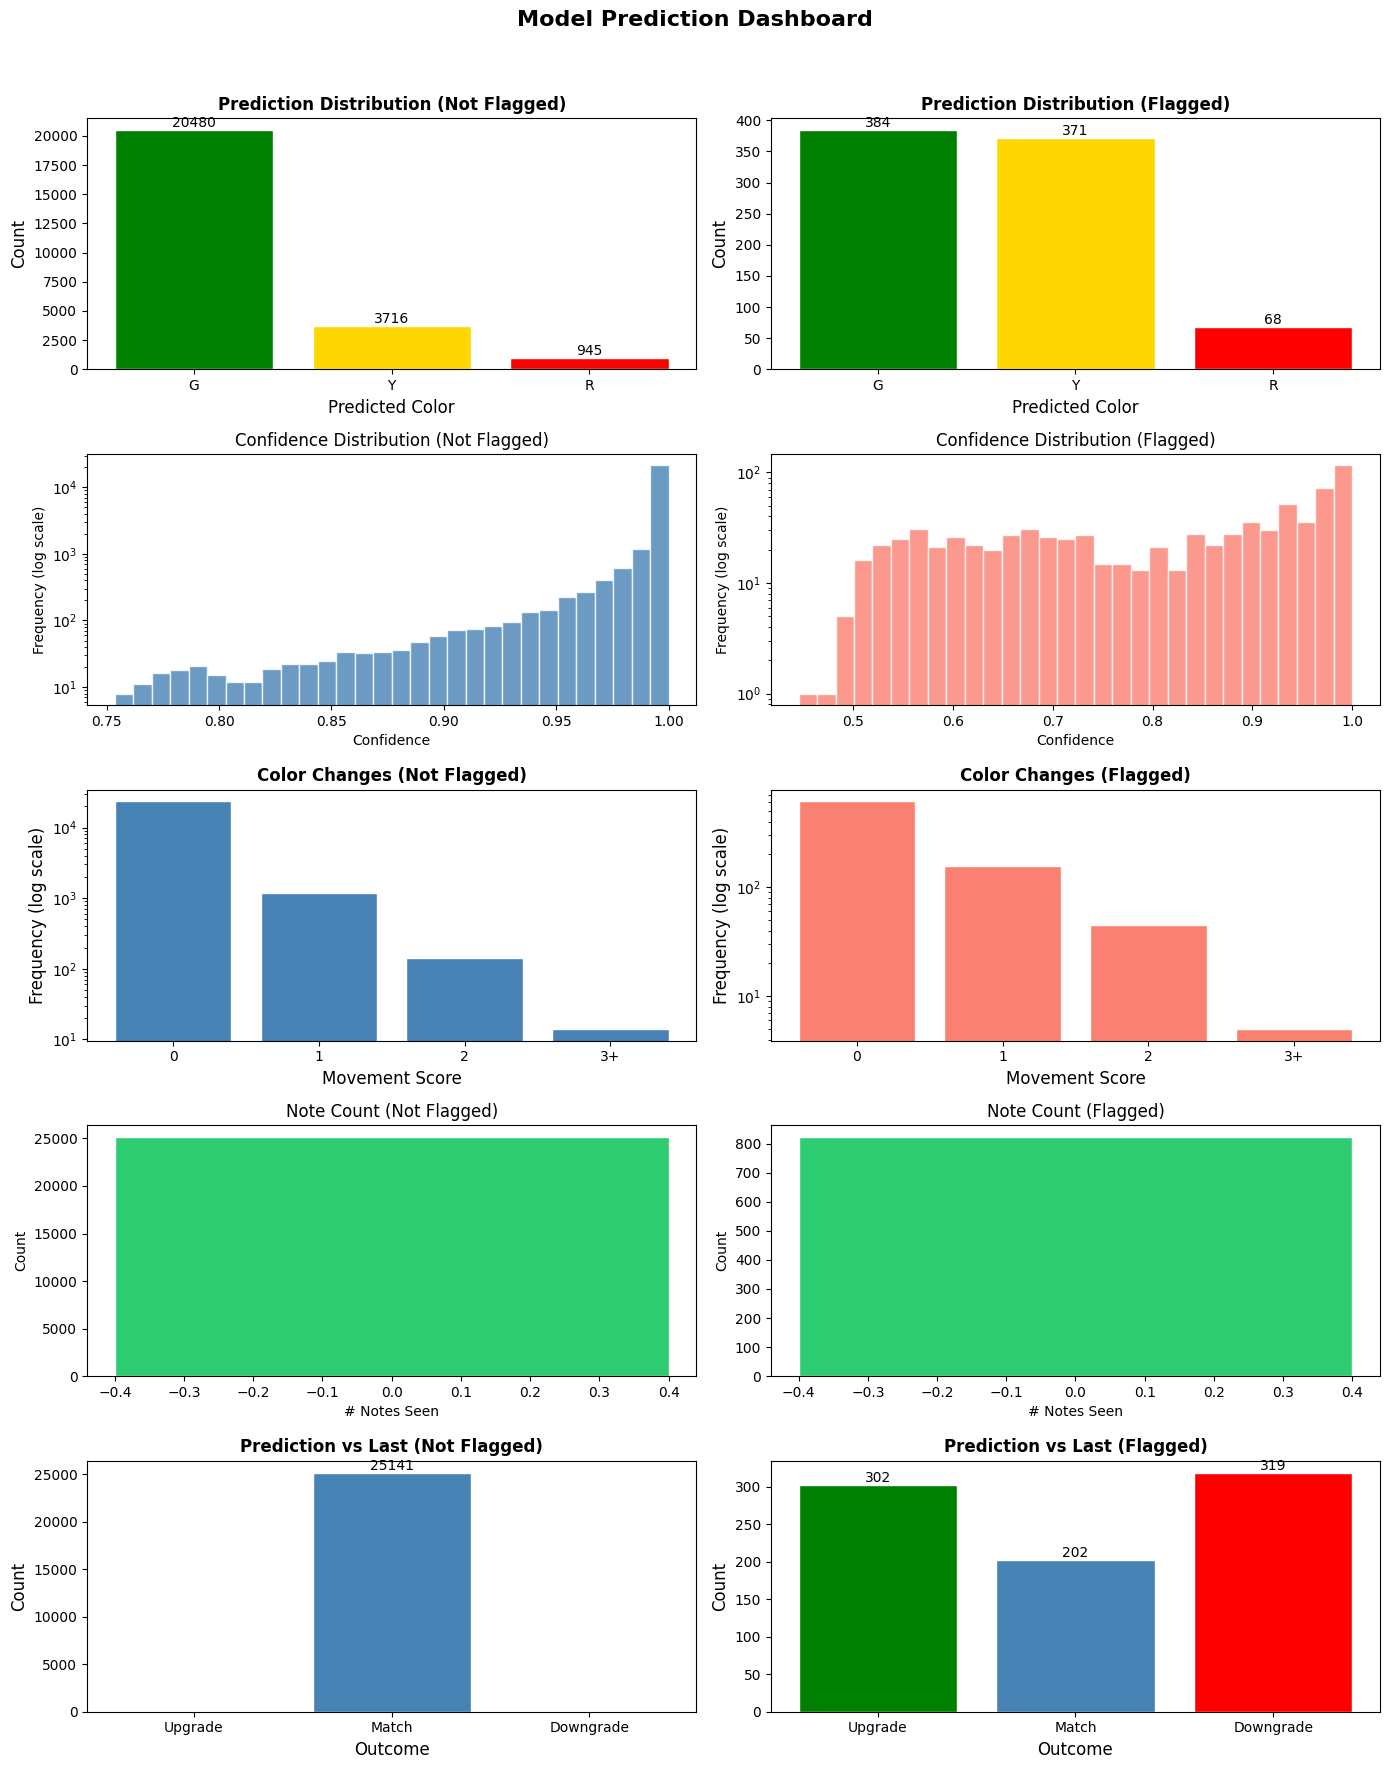

In [27]:
# Generate the 5x2 prediction dashboard
print("=" * 70)
print("PREDICTION DASHBOARD (5x2 Grid)")
print("=" * 70)
print("\nThis dashboard compares Flagged vs Not Flagged predictions across")
print("multiple dimensions: color distribution, confidence, movement, etc.\n")

fig = plot_prediction_dashboard(enriched_report, figsize=(14, 18))

## 12. Upload Module - SQL Server Integration

The new `upload` module provides functionality to upload model predictions to SQL Server for downstream consumption. It handles:
- Building the upload table with proper column mapping
- Schema validation and string truncation
- Bulk upload with progress tracking

In [28]:
# Demo the upload module (DRY RUN - no actual upload)
print("=" * 70)
print("UPLOAD MODULE DEMO")
print("=" * 70)

# Build the upload table without actually uploading
# This transforms predictions into the SQL-ready format

from scorecard.upload import build_upload_table, get_upload_engine, get_schema_info, preflight_report, build_length_map

# Use predictions from sid_df which has the training window format
upload_source = state.sid_df.copy()

# Add required columns for upload if they don't exist
if 'justification' not in upload_source.columns and 'gpt_justification' in state.complete_df.columns:
    # Merge justifications from complete_df
    justification_map = state.complete_df.set_index('sid_key')['gpt_justification'].to_dict()
    upload_source['justification'] = upload_source['sid_key'].map(justification_map)

print(f"Source data shape: {upload_source.shape}")
print(f"Source columns: {list(upload_source.columns[:15])}...")

# Build the upload table
MODEL_NUMBER = 11  # Increment for new model version

try:
    upload_table = build_upload_table(upload_source, model_number=MODEL_NUMBER, verbose=True)
    
    print(f"\nUpload Table Shape: {upload_table.shape}")
    print(f"\nUpload Table Columns:")
    for col in upload_table.columns:
        print(f"  - {col}")
    
    print(f"\nSample rows:")
    display(upload_table.head(3))
except Exception as e:
    print(f"Error building upload table: {e}")
    upload_table = None

UPLOAD MODULE DEMO
Source data shape: (25964, 33)
Source columns: ['sid', 'more_than_4', 'total_notes', 'sid_key_0', 'main_words_0', 'Color_Code_0', 'sid_key_1', 'main_words_1', 'Color_Code_1', 'sid_key_2', 'main_words_2', 'Color_Code_2', 'sid_key_3', 'main_words_3', 'Color_Code_3']...
Error building upload table: 'SID'


In [29]:
# To perform actual upload, use upload_predictions_to_sql()
# NOTE: This is commented out to prevent accidental uploads

"""
# Full upload example:
from scorecard import upload_predictions_to_sql

stats = upload_predictions_to_sql(
    df=upload_source,
    config=config,
    model_number=MODEL_NUMBER,
    table_name="Scorecard_Spark_Model",
    dry_run=False,  # Set True to validate without uploading
    verbose=True
)

print(f"Upload Stats: {stats}")
"""

print("=" * 70)
print("UPLOAD USAGE EXAMPLE")
print("=" * 70)
print("""
To upload predictions to SQL Server:

    from scorecard import upload_predictions_to_sql

    stats = upload_predictions_to_sql(
        df=state.sid_df,               # Your prediction DataFrame
        config=config,                  # ScoreCardConfig with SQL settings
        model_number=11,               # Model version number
        table_name="Scorecard_Spark_Model",
        dry_run=False,                 # Set True to validate only
        verbose=True
    )

The upload module will:
  1. Connect to SQL Server using config credentials
  2. Transform data to match SQL schema
  3. Validate string lengths and truncate if needed
  4. Bulk insert with progress tracking
""")

UPLOAD USAGE EXAMPLE

To upload predictions to SQL Server:

    from scorecard import upload_predictions_to_sql

    stats = upload_predictions_to_sql(
        df=state.sid_df,               # Your prediction DataFrame
        config=config,                  # ScoreCardConfig with SQL settings
        model_number=11,               # Model version number
        table_name="Scorecard_Spark_Model",
        dry_run=False,                 # Set True to validate only
        verbose=True
    )

The upload module will:
  1. Connect to SQL Server using config credentials
  2. Transform data to match SQL schema
  3. Validate string lengths and truncate if needed
  4. Bulk insert with progress tracking



## 13. Final Summary

In [30]:
print("=" * 70)
print("FINAL PIPELINE SUMMARY")
print("=" * 70)

# Core pipeline stats
print("\n--- Core Pipeline ---")
summary = {
    "Enriched Notes": len(state.enriched_df) if state.enriched_df is not None else 0,
    "Training Windows": len(state.sid_df) if state.sid_df is not None else 0,
    "Complete DataFrame": len(state.complete_df) if state.complete_df is not None else 0,
    "Models Trained": len(state.best_model_key_by_horizon),
    "Horizons": list(state.best_model_key_by_horizon.keys()),
}
for key, value in summary.items():
    print(f"  {key}: {value}")

# Model performance
print("\n--- Model Performance (Test Set) ---")
for h_int in state.best_model_key_by_horizon.keys():
    model_info = state.best_model_by_horizon.get(h_int, {})
    accuracy = model_info.get('accuracy', 0)
    false_negs = model_info.get('total_false_negatives', 0)
    print(f"  H{h_int}: Accuracy={accuracy:.4f}, False Negatives={false_negs}")

# Color change analysis
print("\n--- Color Change Predictions ---")
if state.complete_df is not None:
    analysis = analyze_color_changes(state.complete_df, '')
    if analysis is not None:
        total = len(analysis)
        changes = analysis['is_change'].sum()
        downgrades = (analysis['change_type'] == 'Downgrade (Worse)').sum()
        print(f"  Total Predictions: {total:,}")
        print(f"  Predicted Changes: {changes:,} ({100*changes/total:.1f}%)")
        print(f"  Predicted Downgrades: {downgrades:,} ({100*downgrades/total:.1f}%)")

# Reporting stats
print("\n--- Flagged for Review ---")
if 'enriched_report' in dir():
    flagged = enriched_report['Flagged'].sum()
    total = len(enriched_report)
    print(f"  Flagged Predictions: {flagged:,} / {total:,} ({100*flagged/total:.1f}%)")

print("\n" + "=" * 70)
print("Pipeline complete! New modules available:")
print("  - scorecard.upload: SQL Server upload functionality")
print("  - scorecard.reports: Dashboard and reporting tools")
print("=" * 70)

FINAL PIPELINE SUMMARY

--- Core Pipeline ---
  Enriched Notes: 29282
  Training Windows: 25964
  Complete DataFrame: 29282
  Models Trained: 2
  Horizons: [1, 2]

--- Model Performance (Test Set) ---
  H1: Accuracy=0.9651, False Negatives=83
  H2: Accuracy=0.9731, False Negatives=57

--- Color Change Predictions ---
  Total Predictions: 25,964
  Predicted Changes: 621 (2.4%)
  Predicted Downgrades: 319 (1.2%)

--- Flagged for Review ---
  Flagged Predictions: 823 / 25,964 (3.2%)

Pipeline complete! New modules available:
  - scorecard.upload: SQL Server upload functionality
  - scorecard.reports: Dashboard and reporting tools
